# Segmenting Credit Card Customers

In this project, our aim is to segment a group of credit card customers into diferent groups so that different business strategies can be determined for each group. We will work with a data set that is provided by Dataquest in one of their guided projects.

We will use the K-means algorithm to segment our data set. After preparing the data, deciding on the number of clusters, and segmenting the data, we will interpret the results to give a brief explanation about what makes each group different.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline

In [30]:
df = pd.read_csv('files/customer_segmentation.csv')
df.shape

(10127, 14)

In [31]:
df.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

The following data dictionary is provided:

- `customer_id`: unique identifier for each customer.
- `age`: customer age in years.
- `gender`: customer gender (M or F).
- `dependent_count`: number of dependents of each customer.
- `education_level`: level of education ("High School", "Graduate", etc.).
- `marital_status`: marital status ("Single", "Married", etc.).
- `estimated_income` : the estimated income for the customer projected by the data science team.
- `months_on_book`: time as a customer in months.
- `total_relationship_count`: number of times the customer contacted the company.
- `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
- `credit_limit`: customer's credit limit.
- `total_trans_amount`: the overall amount of money spent on the card by the customer.
- `total_trans_count`: the overall number of times the customer used the card.
- `avg_utilization_ratio`: daily average utilization ratio.

Our data set doesn't have any null values. Aside from the `customer_id` column, which is not relevant to our segmentation, we have 3 categorical features, and 10 numerical ones. We make a list of each group for future use:

In [33]:
numerical_cols = ['age', 'dependent_count', 'estimated_income',
                  'months_on_book', 'total_relationship_count',
                  'months_inactive_12_mon', 'credit_limit',
                  'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio']

categorical_cols = ['gender', 'education_level', 'marital_status']

### Categorical variables:

In [34]:
for c in categorical_cols:
    print(f"Categories in {c}:")
    print(df[c].value_counts())
    print()

Categories in gender:
F    5358
M    4769
Name: gender, dtype: int64

Categories in education_level:
Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

Categories in marital_status:
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64



Here we note that `gender` and `marital_status` are nominal data whereas `education_level` is ordinal; we can assign integers to `education_level` that corresponds to an order, but it is not possible to order the values of the other two. We will come back to this when we encode categorical data before applying K-means.

### Numerical variables:

In order to get a general understanding of the numerical data, we will look at correlations and plot distributions.

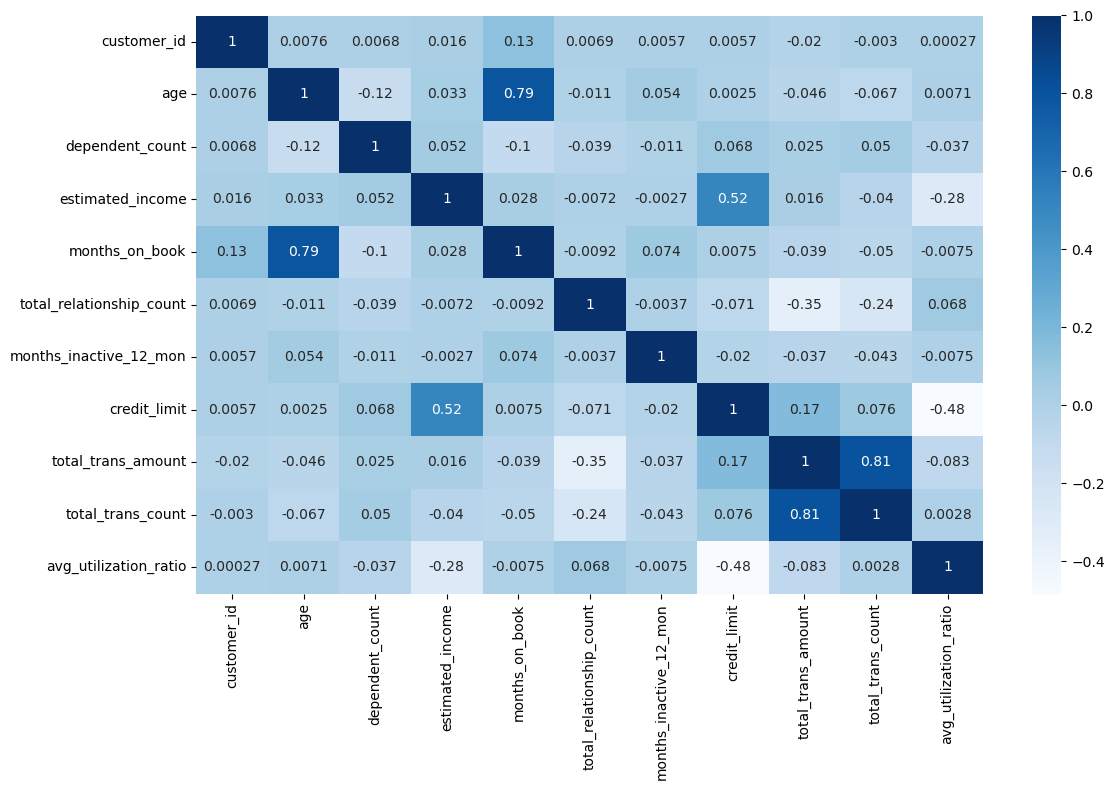

In [35]:
correlations = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='Blues')
plt.tight_layout()
plt.show()

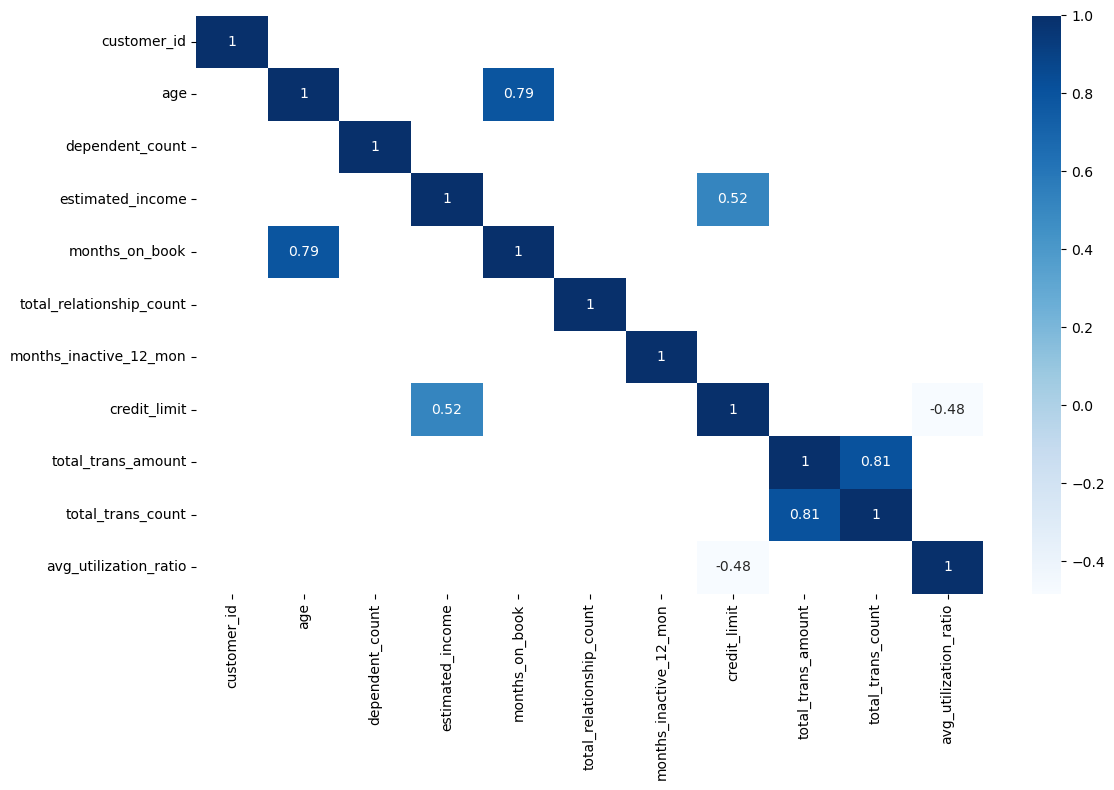

In [36]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlations[correlations.abs() > 0.4],
            annot=True, cmap='Blues')
plt.tight_layout()
plt.show()

Most of the correlations are weak, but we can note the following:

- `total_trans_amount` is strongly positively correlated with `total_trans_count`

- `age` is strongly positively correlated with `months_on_book`

- `credit_limit` is positively correlated with `estimated_income`, and negatively correlated with `avg_utilization_ratio`, although the correlations are not as strong as the ones above

/var/folders/v0/5t8pswf91nb01hqt5vjpg_b00000gn/T/ipykernel_4782/3964196452.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_no_id.hist(ax=ax)


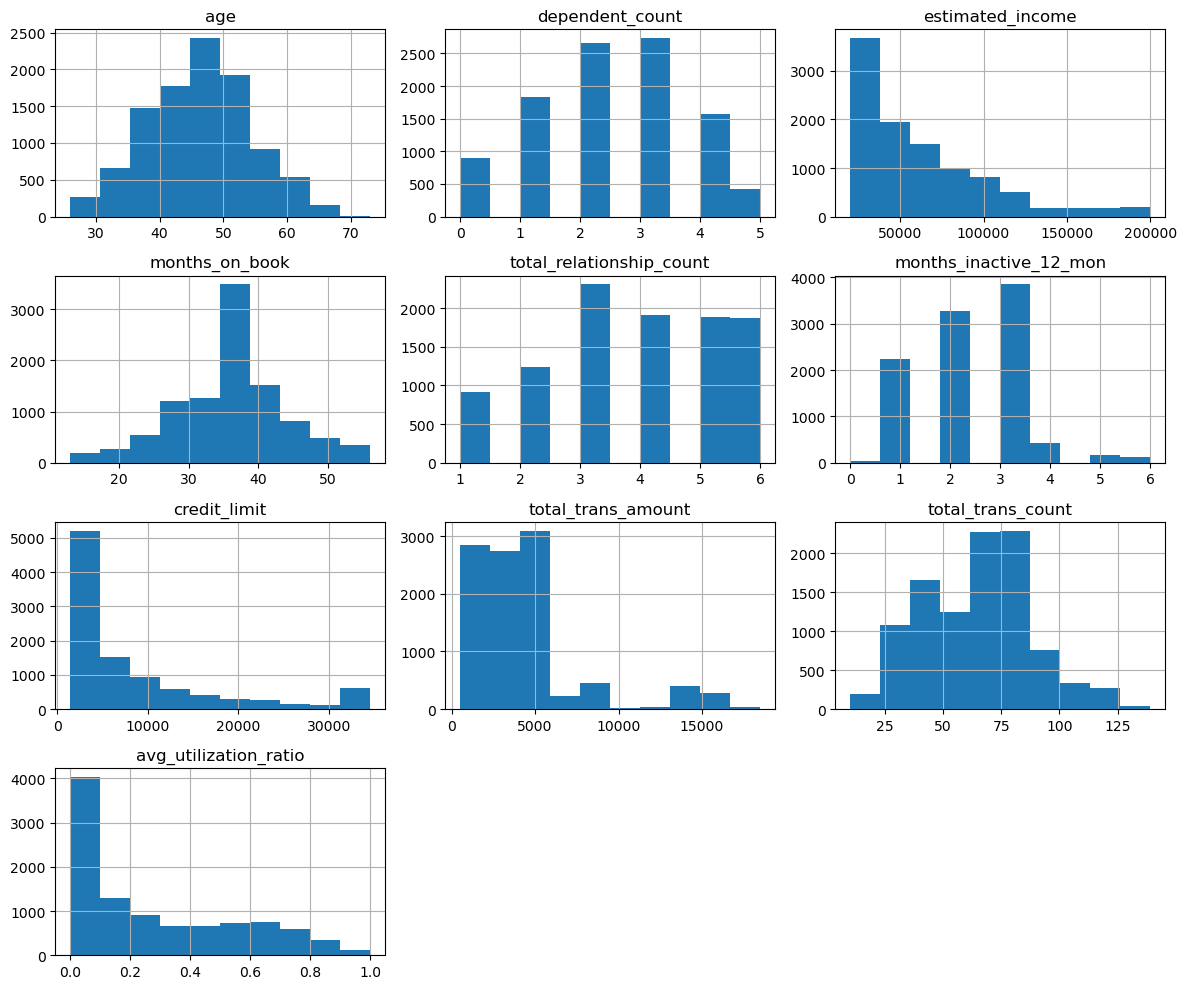

In [37]:
# Look at distributions
df_no_id = df.drop('customer_id', axis=1)
fig, ax = plt.subplots(figsize=(12, 10))
df_no_id.hist(ax=ax)
plt.tight_layout()
plt.show()

We see that, among the numerical data, `age`, `months_on_book` and `dependent_count` are closer to a normal distribution, whereas `credit_limit`, `avg_utilization_ratio` and `estimated_income` are strongly right-skewed. Also, it's worth noting that `total_amount_count` is closer to a normal distribution while `total_trans_amount` is very skewed..

## Feature engineering

We move on to preparing our data set for our model. We will start with the categorical columns. First we remove `customer_id` as it is not relevant for our model. We keep the original data set as we will come back to it to assign clusters at the end.

In [38]:
df_modif = df.copy()
df_modif.drop('customer_id', axis=1, inplace=True)

As we observed before, we can assign integers from 1 to 6 for the `education_level` column as we can order the level of education.

In [39]:
df_modif['education_level'] = df_modif['education_level'].map(
    {'Uneducated': 0, 'High School': 1, 'College': 2,
     'Graduate': 3,'Post-Graduate': 4, 'Doctorate': 5}
)
df_modif['education_level'].value_counts().sort_index()

0    1755
1    2351
2    1192
3    3685
4     616
5     528
Name: education_level, dtype: int64

We cannot order `gender`, but since there's only two values in this data set, we can encode them as 0 or 1.

In [40]:
df_modif['gender'] = df_modif['gender'].map({'M':0, 'F':1})
df_modif['gender'].value_counts()

1    5358
0    4769
Name: gender, dtype: int64

With the `marital_status` column, we have 4 unique values we can't order, so we will get dummy variables for this column.

In [41]:
df_modif = pd.get_dummies(data=df_modif, columns=['marital_status'], drop_first=True)
df_modif.head()

,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,45,0,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,49,1,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,51,0,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,40,1,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,40,0,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## Choosing the number of clusters

Now that our data set is ready, we move on to scaling our data.

In [42]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_modif)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.165406,-1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,1.077338,-0.798507,-0.282609
1,0.333570,0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.928214,1.252337,-0.282609
2,0.583058,-1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,1.077338,-0.798507,-0.282609
3,-0.789126,0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.928214,-0.798507,3.538459
4,-0.789126,-1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,1.077338,-0.798507,-0.282609


Next we will compare inertias corresponding to k values from 1 to 10 in order to determine the optimal k value.

In [43]:
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(df_scaled)
    inertias.append(model.inertia_)

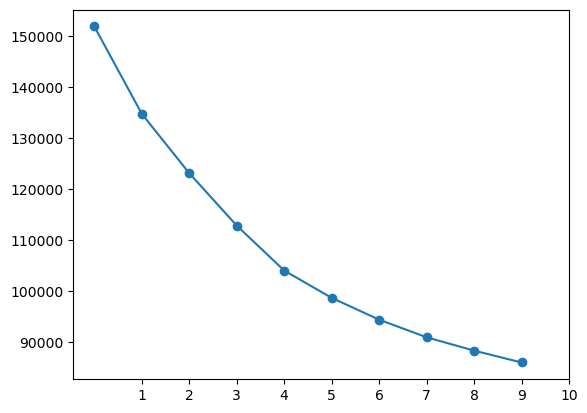

In [44]:
# Plot the elbow curve
plt.plot(inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.show()

There isn't a clear elbow in this graph, but we can see that the decrease slows down between k=4 and k=5, so we'll choose 6 for the number of clusters.

In [45]:
model = KMeans(n_clusters=6)
clusters = model.fit_predict(df_scaled)

## Interpreting results

We go back to the original data set and add a `cluster` column for the values assigned to each data point.

In [46]:
df['cluster'] = clusters + 1
df['cluster'].value_counts()

3    2789
2    2491
5    1757
4    1446
1     910
6     734
Name: cluster, dtype: int64

Now we look at the distribution of each numerical variable over clusters.

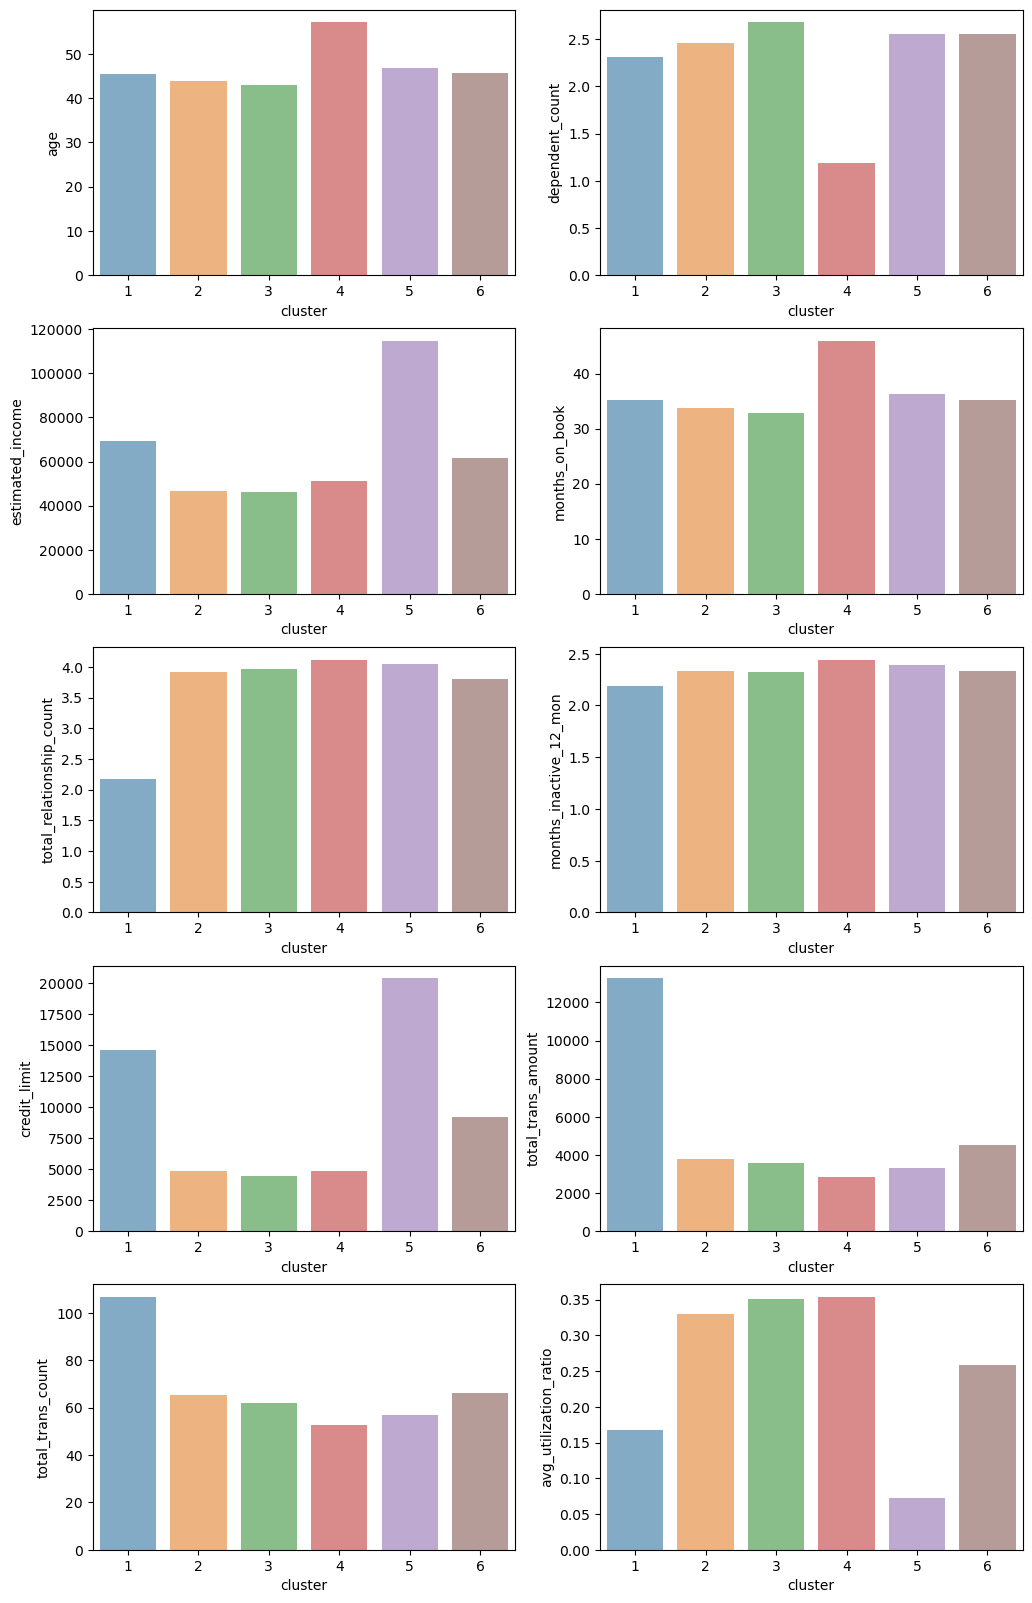

In [50]:
plt.figure(figsize=(12, 20))
for i, c in enumerate(numerical_cols):
    plt.subplot(5, 2, i+1)
    means = df.groupby('cluster')[c].mean()
    sns.barplot(x=means.index, y=means, alpha=0.6)
plt.show()

We also consider scatter plots for the most correlated numerical variables we saw before.

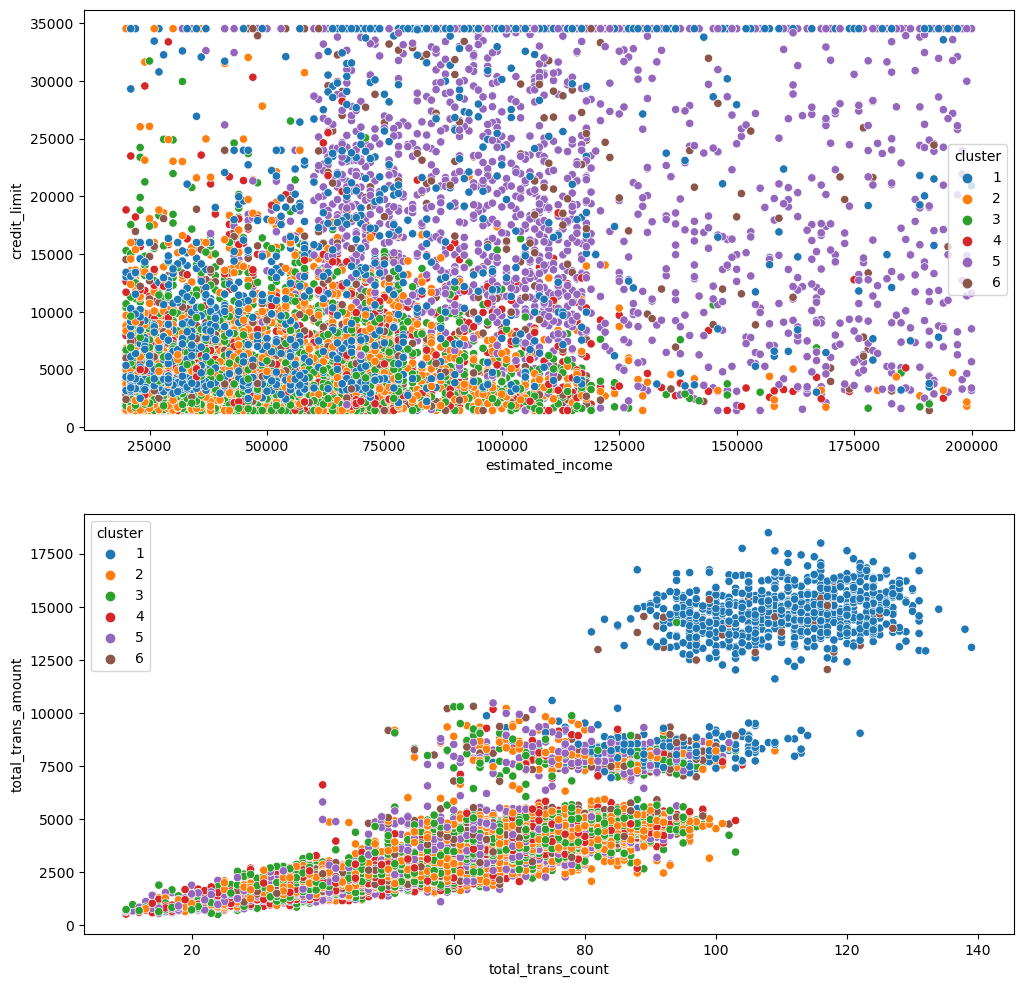

In [51]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
sns.scatterplot(data=df, x='estimated_income', y='credit_limit',
                hue='cluster', palette='tab10')
plt.subplot(2, 1, 2)
sns.scatterplot(data=df, x='total_trans_count', y='total_trans_amount',
                hue='cluster', palette='tab10')
plt.show()

We see that Cluster 2 has generally low income and credit limit while Cluster 5 has the highest averages. We also see that Cluster 1 has the highest transaction count and amount by a large margin when compared to other clusters.

Finally we consider some plots for our categorical variables:

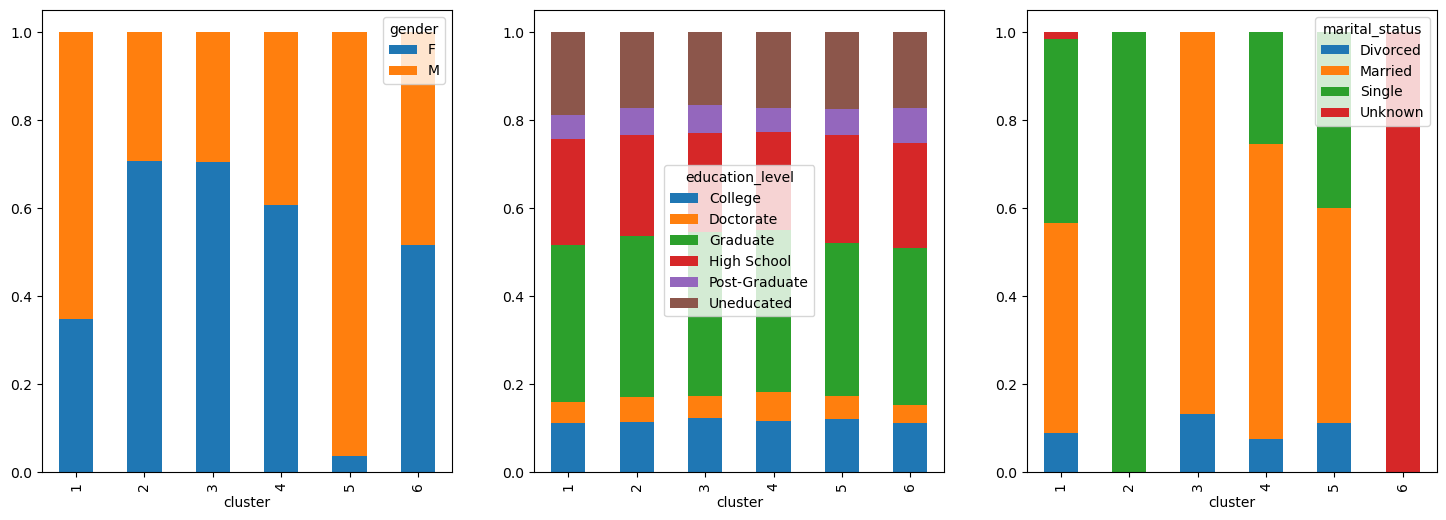

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, c in enumerate(categorical_cols):
    plot_df = pd.crosstab(
        index=df['cluster'], columns=df[c], values=df[c],
        aggfunc='size', normalize='index'
    )
    plot_df.plot.bar(ax=axs[i], stacked=True)
plt.show()

We see that the education level is evenly distributed among clusters, but we can't say the same for gender or marital status.

## Conclusion

Now we use all our plots to make a brief explanation about what characteristics each cluster has.

#### Cluster 1:

- Highest transaction averages (highest amount/count ratio which implies largest purchases)
- High credit limit and estimated income (second among clusters)
- Low daily average utilization ratio
- Low number of contacts with company, separating characteristic from others
- More males than females, mostly single or married

Cluster 1 could be encouraged to use their credit cards more.


#### Cluster 2:

- Low transaction averages
- Low credit limit and lowest estimated income
- High daily average utilization ratio
- High number of contacts with company
- Mostly females, and all singles


#### Cluster 3:

- Low transaction averages
- Low credit limit and estimated income
- High daily average utilization ratio
- High number of contacts with company
- Mostly females; big majority is married, others divorced
- Highest number of dependents which, when combined with the last point, implies expenses related to raising children


#### Cluster 4:

- Lowest transaction averages
- Low credit limit and estimated income
- Highest daily average utilization ratio
- Highest number of contacts with company
- Age average highest among clusters, and longest time being a customer, separating characteristic from others
- Slightly more men than women, mostly married, some single or divorced
- Dependent count lowest among clusters, separating characteristic from others


#### Cluster 5

- Low transaction averages
- Highest estimated income and highest credit limit
- Lowest daily average utilization ratio
- High number of contacts with company
- Almost all males, half married, half single or divorced

Cluster 5 could be encouraged to use their credit card more.


#### Cluster 6

- Low but second best transaction averages
- Relatively high credit limit and estimated income (in top 3)
- High daily average utilization ratio
- Evenly separated between males and females
- Marital status completely unknown, separating characteristic from others